# Differential Peak Shape

**Created**: 24 April 2022

## Environment

In [1]:
library(tidyverse)
library(data.table)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [14]:
shape.features.dir <- "/nfs/users/nfs_n/nm18/gains_team282/epigenetics/regulation/immune/shape_features/"

shape.features <- do.call(rbind, lapply(list.files(shape.features.dir, pattern="*consensus_shape_features.csv"), function(file.name) {
    fread(paste0(shape.features.dir, file.name))
}))

In [15]:
dim(shape.features)

[1]    171 296576

In [18]:
tss.enrichment.scores <- read.table("/nfs/users/nfs_n/nm18/gains_team282/epigenetics/accessibility/analysis/atac_seq/tss_enrichment_scores.tsv", header=T)

In [19]:
head(tss.enrichment.scores)

,Sample,TSS_Enrichment_Score
,<chr>,<dbl>
1,Calderon-1001-Memory_Teffs-Control,35.71484
2,Calderon-1001-Myeloid_DCs-Control,24.90297
3,Calderon-1003-CD8pos_T-Treatment_1,24.91672
4,Calderon-1001-Regulatory_T-Control,30.79065
5,Calderon-1003-Effector_memory_CD8pos_T-Treatment_1,31.39529
6,Calderon-1001-Memory_Tregs-Control,35.20552


In [22]:
atac.meta <- read.csv("/nfs/users/nfs_n/nm18/eQTL_pQTL_Characterization/03_Functional_Interpretation/metadata/reads_atac_seq.txt")

In [23]:
head(atac.meta)

,Run,Group.ID,Sample.ID,Donor,Lineage,Cell_type,Stimulated,Treatment,Replicate,Assay.Type,⋯,Experiment,Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,Sample.Name,SRA.Study
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR2920475,Corces-4983-Monocytes-Control,Corces-4983-Monocytes-Control-1,Corces-4983,MYELOID,Monocytes,FALSE,Control,1,ATAC-Seq,⋯,SRX1427798,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937385,SRP066100
2,SRR2920488,Corces-6792-Monocytes-Control,Corces-6792-Monocytes-Control-1,Corces-6792,MYELOID,Monocytes,FALSE,Control,1,ATAC-Seq,⋯,SRX1427811,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937398,SRP066100
3,SRR2920476,Corces-4983-Monocytes-Control,Corces-4983-Monocytes-Control-2,Corces-4983,MYELOID,Monocytes,FALSE,Control,2,ATAC-Seq,⋯,SRX1427799,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937386,SRP066100
4,SRR2920487,Corces-6792-Monocytes-Control,Corces-6792-Monocytes-Control-2,Corces-6792,MYELOID,Monocytes,FALSE,Control,2,ATAC-Seq,⋯,SRX1427810,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937397,SRP066100
5,SRR2920542,Corces-7256-Monocytes-Control,Corces-7256-Monocytes-Control-1,Corces-7256,MYELOID,Monocytes,FALSE,Control,1,ATAC-Seq,⋯,SRX1427865,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937452,SRP066100
6,SRR2920543,Corces-7256-Monocytes-Control,Corces-7256-Monocytes-Control-2,Corces-7256,MYELOID,Monocytes,FALSE,Control,2,ATAC-Seq,⋯,SRX1427866,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937453,SRP066100


In [44]:
data.mtx <- atac.meta %>%
    dplyr::select(Group.ID, Donor, Cell_type, Stimulated) %>%
    dplyr::mutate(Stimulated=ifelse(Stimulated, "Stimulated", "Control")) %>%
    dplyr::mutate(Group=interaction(Cell_type, Stimulated)) %>%
    dplyr::select(Group.ID, Donor, Group) %>%
    merge(., tss.enrichment.scores, by.x="Group.ID", by.y="Sample") %>%
    merge(., shape.features, by.x="Group.ID", by.y="Sample")

In [45]:
head(data.mtx[,1:10])

,Group.ID,Donor,Group,TSS_Enrichment_Score,1:804821-805016,1:812642-812879,1:815224-815554,1:817057-817622,1:819712-820327,1:821473-823221
,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Calderon-1001-Bulk_B-Control,Calderon-1001,Bulk_B.Control,24.89519,-0.1423596,0.07229998,0.91331133,0.088479460,-0.06979769,-0.0746096
2,Calderon-1001-Bulk_B-Treatment_1,Calderon-1001,Bulk_B.Stimulated,26.17991,-0.1712491,0.07229998,-0.18299406,0.100023190,-0.05612937,-0.1170483
3,Calderon-1001-Central_memory_CD8pos_T-Control,Calderon-1001,Central_memory_CD8pos_T.Control,27.64371,0.0690419,0.17290578,0.07028024,0.095439393,-0.14628528,-0.1383488
4,Calderon-1001-Central_memory_CD8pos_T-Treatment_1,Calderon-1001,Central_memory_CD8pos_T.Stimulated,21.34979,-0.1054197,0.26552140,0.07028024,0.194753166,-0.11220044,-0.1140524
5,Calderon-1001-Effector_CD4pos_T-Control,Calderon-1001,Effector_CD4pos_T.Control,32.60889,0.9257329,-0.17381919,0.14926360,-0.002967073,0.09602181,-0.1542764
6,Calderon-1001-Effector_CD4pos_T-Treatment_1,Calderon-1001,Effector_CD4pos_T.Stimulated,25.63847,-0.1668195,-0.19535193,0.50041493,0.001737872,0.05777375,-0.1302668


## Linear Model

In [46]:
f <- as.formula(paste0("`1:804821-805016`", "~Donor+TSS_Enrichment_Score+Group"))
lm(f, data=data.mtx)


Call:
lm(formula = f, data = data.mtx)

Coefficients:
                             (Intercept)  
                               0.1911797  
                      DonorCalderon-1002  
                              -0.2783306  
                      DonorCalderon-1003  
                              -0.0844372  
                      DonorCalderon-1004  
                              -0.0185201  
                      DonorCalderon-1008  
                              -0.3055371  
                      DonorCalderon-1010  
                              -0.3608206  
                      DonorCalderon-1011  
                               0.2420579  
                        DonorCorces-4983  
                              -0.0288141  
                        DonorCorces-6792  
                              -0.0322506  
                        DonorCorces-7256  
                              -0.0306085  
                    TSS_Enrichment_Score  
                              -0.0004311  

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



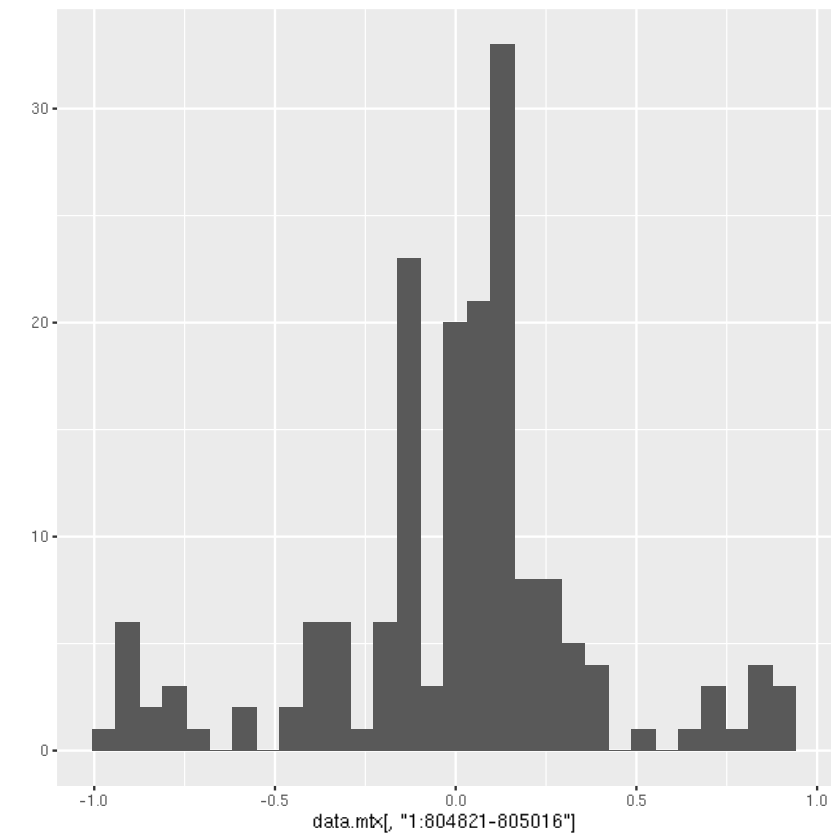

In [40]:
qplot(data.mtx[,"1:804821-805016"])